In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence

from keras import layers
from keras.models import Model

In [2]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data.head(50)

data = data.fillna(method="ffill")
data.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [4]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

words=list(data['Word'].unique())
words.append("ENDPAD")
num_words = len(words)
tags=list(data['Tag'].unique())
num_tags = len(tags)

print("Unique tags are:", tags)

Unique words in corpus: 24910
Unique tags in corpus: 17
Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


In [5]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:
getter = SentenceGetter(data)
sentences = getter.sentences
len(sentences)

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
X1 = [[word2idx[w[0]] for w in s] for s in sentences]

In [7]:
max_len = 100
X = sequence.pad_sequences(maxlen=max_len,
                  sequences=X1, padding="post",
                  value=num_words-1)

y1 = [[tag2idx[w[2]] for w in s] for s in sentences]

y = sequence.pad_sequences(maxlen=max_len,
                  sequences=y1,
                  padding="post",
                  value=tag2idx["O"])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=1)

In [8]:
input_word = layers.Input(shape=(max_len,))

embedding_layer = layers.Embedding(input_dim=num_words,output_dim=50,
                                   input_length=max_len)(input_word)

dropout = layers.SpatialDropout1D(0.1)(embedding_layer)

bid_lstm = layers.Bidirectional(
    layers.LSTM(units=100,return_sequences=True,
                recurrent_dropout=0.1))(dropout)

output = layers.TimeDistributed(
    layers.Dense(num_tags,activation="softmax"))(bid_lstm)

model = Model(input_word, output)

model.summary()

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.fit(x=X_train, y=y_train, validation_data=(X_test,y_test),
          batch_size=50, epochs=3,)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           1245550   
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 50)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 100, 200)          120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 100, 17)           3417      
 ributed)                                                        
                                                             

<Axes: >

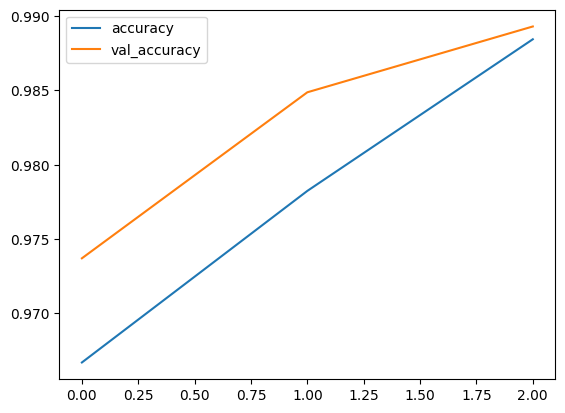

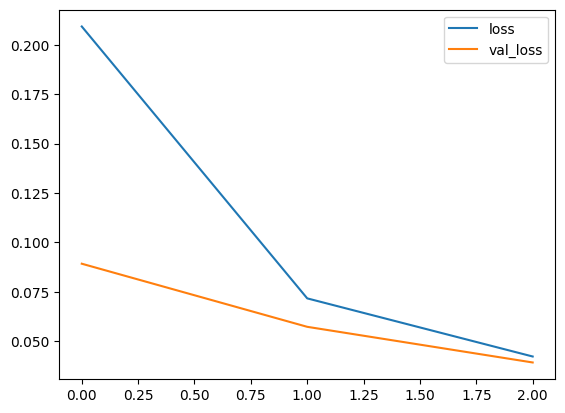

In [12]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

metrics[['accuracy','val_accuracy']].plot()
metrics[['loss','val_loss']].plot()

In [13]:
i = 20
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 1s 868ms/step
Word           True 	 Pred

------------------------------
Authorities    O	O
in             O	O
Morocco        B-geo	B-geo
and            O	O
Turkey         B-geo	B-geo
have           O	O
arrested       O	O
two            O	O
men            O	O
blamed         O	O
for            O	O
unleashing     O	O
a              O	O
computer       O	O
worm           O	O
that           O	O
disrupted      O	O
networks       O	O
across         O	O
the            O	O
United         B-geo	B-geo
States         I-geo	I-geo
last           O	O
week           O	O
.              O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
seals          O	O
s